In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline,  FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk  
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import     CountVectorizer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import chi2, SelectKBest
import spacy
from sklearn.preprocessing import MaxAbsScaler


In [20]:
df=pd.read_csv('airlines.csv')
print(df.columns)


df['recommended']=df['recommended'].apply(lambda x: 1 if x=='YES' else 0)
df=df.sort_values(by='date')
df['year']=pd.to_datetime(df['date']).dt.year
encoder=LabelEncoder()
df['airline_enc']=encoder.fit_transform(df['airline'])
df['location_enc']=encoder.fit_transform(df['location'])
df['cabin_enc']=encoder.fit_transform(df['cabin'])


dictAirline= df[['airline_enc','airline']].set_index('airline_enc').to_dict()
dictLocation= df[['location_enc','location']].set_index('location_enc').to_dict()
#print(dictAirline)
#print(df.head())

Index(['Unnamed: 0', 'id', 'airline', 'date', 'location', 'rating', 'cabin',
       'value', 'recommended', 'review'],
      dtype='object')


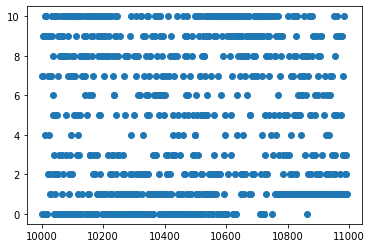

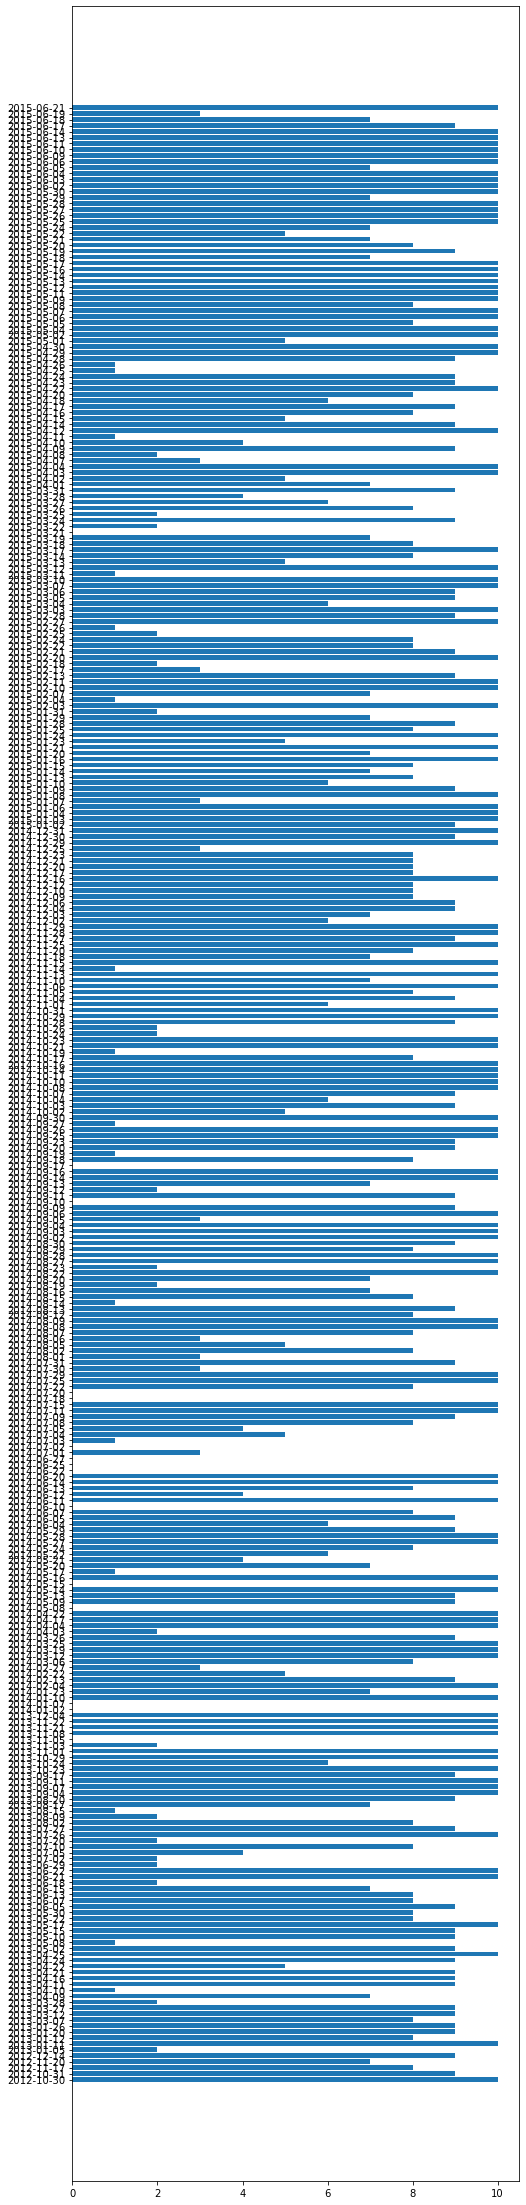

In [21]:

plt.scatter(data=df,y='rating',x='id')
plt.show()

fig,ax = plt.subplots(figsize=(8,40))
ax.barh(df['date'],df['rating'])
plt.show()

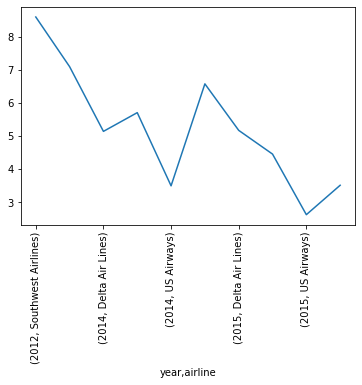

The airline that you fly determines satisification


In [22]:
grouped= df.groupby(['year','airline'])
grouped['rating'].mean().plot()
plt.xticks(rotation=90)
plt.show()

print("The airline that you fly determines satisification")

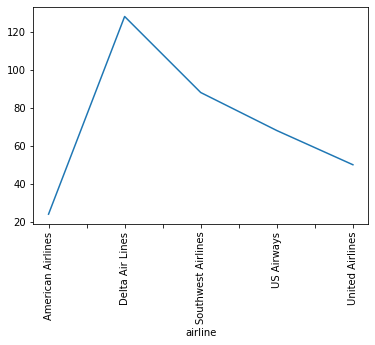

Delta is the highest recommended carrier


In [23]:
grouped= df.groupby(['airline'])
grouped['recommended'].sum().plot()
plt.xticks(rotation=90)
plt.show()

print("Delta is the highest recommended carrier")

C:\Users\dnishimoto.BOISE\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\dnishimoto.BOISE\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\dnishimoto.BOISE\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html


Accuracy on sample data - numeric, no nans:0.91% 


Text(0, 0.5, 'TPR')

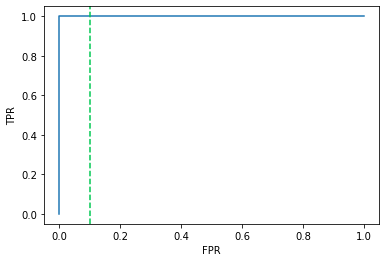

In [24]:
NUMERIC=['value','rating','year','airline_enc','location_enc','cabin_enc']
TEXT=['review']

def combine_text_columns(data_frame, text_labels=TEXT):
    """ converts all text in each row of data_frame to single vector """
    #to_drop = set(to_drop) & set(data_frame.columns.tolist())
    #text_dta=data_frame.drop(to_drop,axis=1)
    text_data =data_frame[text_labels]

    # Replace nans with blanks
    text_data.fillna("",inplace=True)

    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

nlp = spacy.load('en_core_web_sm')
stopwords=spacy.lang.en.stop_words.STOP_WORDS
chi_k = 300
# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'


get_text_data = FunctionTransformer(combine_text_columns,validate=False)

 # Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x:    x[NUMERIC], validate=False)

pl = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('imputer', SimpleImputer())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vectorizer', TfidfVectorizer(stop_words='english')),
                    #('vectorizer',CountVectorizer(stop_words=stopwords,token_pattern=TOKENS_ALPHANUMERIC, ngram_range=(1,2))),('dim_red', SelectKBest(chi2, chi_k))
            ]))
         ]
    )),
    ('scale', MaxAbsScaler()),
    #('svc',LinearSVC())
    #('nb', MultinomialNB()),
    #('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=15)))
    ('lr', OneVsRestClassifier(LogisticRegression(C=100)))
  ])

TARGET=['recommended']    
sc_X = StandardScaler()

X=df[NUMERIC]
X=pd.concat([X,df[TEXT]],axis=1)
y=df[TARGET]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3, random_state=42)

pl.fit(X_train,y_train)
predictions=pl.predict(X_test)
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - numeric, no nans:{:.2f}% ".format(accuracy))
ytrain_pred_probas = pl.predict_proba(X_train)[:, 1]        
# prob of predict as 1
fpr, tpr, thresholds = roc_curve(y_train, ytrain_pred_probas)   # precision_recall_curve
roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})
_ = plt.figure()
plt.plot(roc.FPR, roc.TPR)
plt.axvline(0.1, color = '#00C851', linestyle = '--')
plt.xlabel("FPR")
plt.ylabel("TPR")

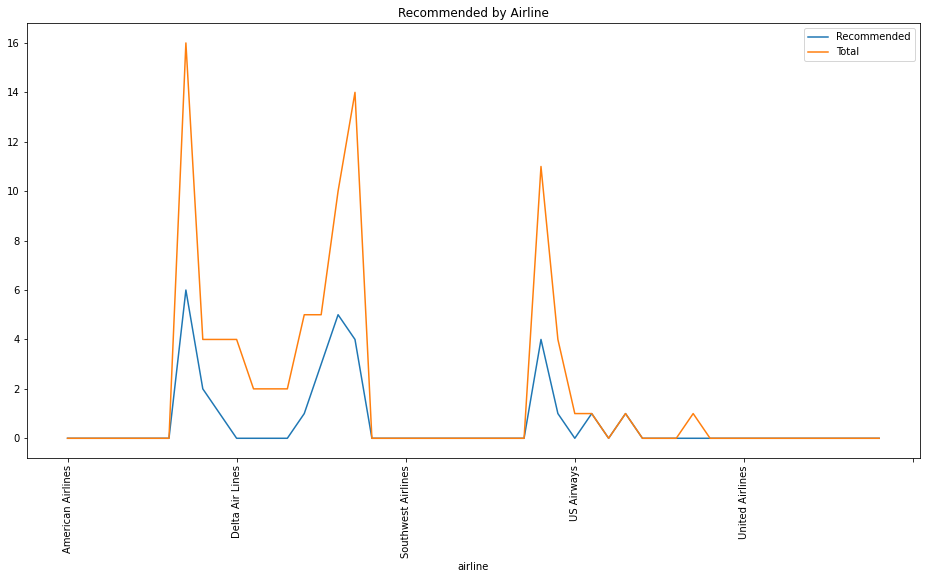

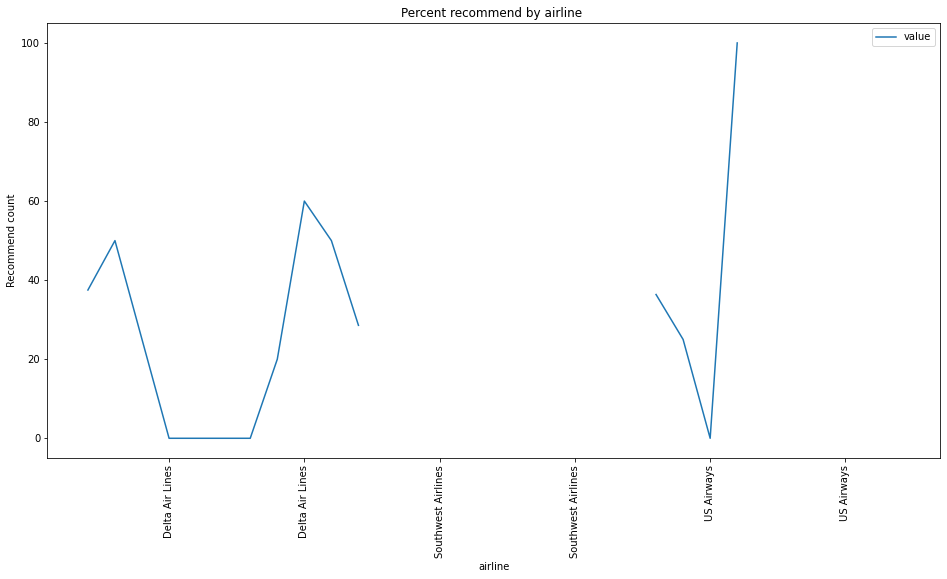

In [54]:

#print(grouped.index,grouped.values)    

def getAirlineByGrouped(grouped,dictGeneric):
    mylist=[]
    for key in grouped.index.get_level_values(0):
        item=dictGeneric.get(key)
        mylist.append(item)
    return mylist

#grouped=X_test.groupby('airline_enc')['rating'].mean()
#grouped.plot()
#plt.title("Rating by Airline")
#plt.show()
#results=pd.concat([X_test[['rating','airline_enc']],pd.Series(predictions, name='recommended')],axis=1)
#print(results)

fig,ax=plt.subplots(figsize=(16,8))
grouped=results.groupby(['airline_enc','rating'])['recommended'].sum()
airlines=getAirlineByGrouped(grouped,dictAirline['airline'])
result_df=pd.DataFrame({'index':grouped.index.get_level_values(0),'value':grouped.values,'airline':airlines})
result_df.plot(x='airline',y='value',ax=ax)
grouped=results.groupby(['airline_enc','rating'])['recommended'].count()
airlines=getAirlineByGrouped(grouped,dictAirline['airline'])
result_df=pd.DataFrame({'index':grouped.index.get_level_values(0),'value':grouped.values,'airline':airlines})
result_df.plot(x='airline',y='value',ax=ax)
plt.xticks(rotation=90)
plt.legend(['Recommended','Total'])
plt.title('Recommended by Airline')
plt.show()

fig,ax=plt.subplots(figsize=(16,8))
grouped=(results.groupby(['airline_enc','rating'])['recommended'].sum()/results.groupby(['airline_enc','rating'])['recommended'].count())*100
airlines=getAirlineByGrouped(grouped,dictAirline['airline'])
result_df=pd.DataFrame({'index':grouped.index.get_level_values(0),'value':grouped.values,'airline':airlines})
result_df.plot(x='airline',y='value',ax=ax)
plt.title("Percent recommend by airline ")
plt.ylabel('Recommend count')
plt.xticks(rotation=90)
plt.show()



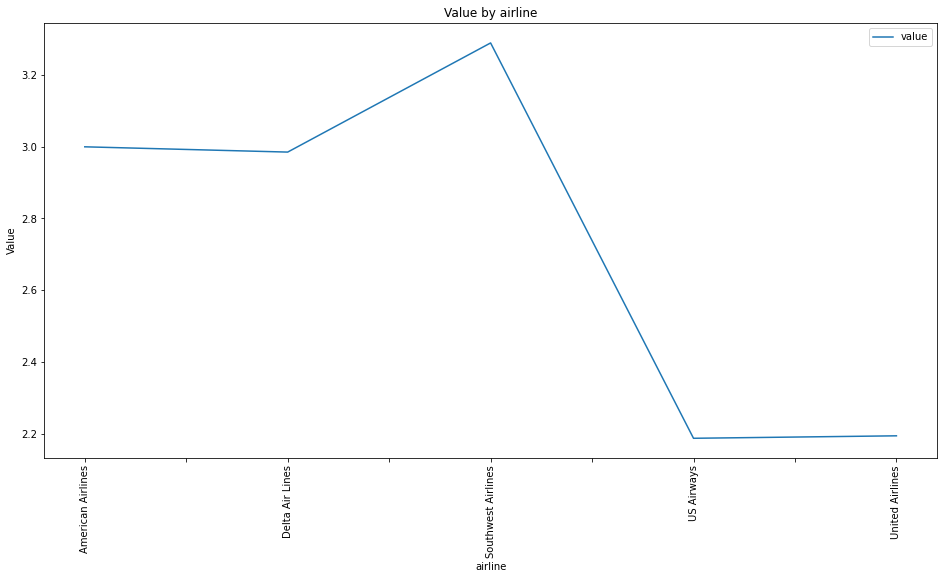

Southwest has the highest value of the airlines


In [55]:
grouped=X_test.groupby('airline_enc')['value'].mean()

airlines=getAirlineByGrouped(grouped,dictAirline['airline'])
#airlines=[]
#for key in grouped.index:
#    item=dictAirline['airline'].get(key)
#    airlines.append(item)
    
result_df=pd.DataFrame({'index':grouped.index,'value':grouped.values,'airline':airlines})
fig,ax=plt.subplots(figsize=(16,8))
result_df.plot(x='airline',y='value',ax=ax)
plt.title("Value by airline")
plt.ylabel('Value')
#lt.legend(handles=[line1,line2])
plt.xticks(rotation=90)
plt.show()

print('Southwest has the highest value of the airlines')
